In [231]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

## Food Safety Inspections

First we want to review and analyze the data. I am using python3 along with this jupyter notebook, package libraries pandas dataframe, numpy and plotly. Initially we want to see what features/columns overlap, which are one off, and which aren't salient or useful. I started out by loading the csv files and reviewing the feature and column names.

In [ ]:
# Load the Data
#df_ny = pd.read_csv('NY.csv', low_memory=False)
#df_chicago = pd.read_csv('Chicago.csv', low_memory=False)
#df_vegas = pd.read_csv('Las_Vegas.csv', low_memory=False)

df_ny = pd.read_csv('https://s3-us-west-2.amazonaws.com/prototype.data/NY.csv', low_memory=False)
df_chicago = pd.read_csv('https://s3-us-west-2.amazonaws.com/prototype.data/Chicago.csv', low_memory=False)
df_vegas = pd.read_csv('https://s3-us-west-2.amazonaws.com/prototype.data/Las_Vegas.csv', low_memory=False)

In [750]:
# Count data size
counts = {"Index":["NY", "Chicago", "Las Vegas"], "Count": [len(df_ny.index), len(df_chicago.index), len(df_vegas.index)]}
records = pd.DataFrame(counts)
records.set_index('Index',inplace=True)
records.index.name = None
records

,Count
NY,383119
Chicago,188205
Las Vegas,180136


In [751]:
# review feature labels
col = {'NY':list(df_ny.columns.values) + [' ']*6,'Chicago':list(df_chicago.columns.values) + [' ']*2, 'Vegas':list(df_vegas.columns.values)}
df_columns = pd.DataFrame(col)
df_columns

,NY,Chicago,Vegas
0,CAMIS,Inspection ID,Serial Number
1,DBA,DBA Name,Permit Number
2,BORO,AKA Name,Restaurant Name
3,BUILDING,License #,Location Name
4,STREET,Facility Type,Category Name
5,ZIPCODE,Risk,Address
6,PHONE,Address,City
7,CUISINE DESCRIPTION,City,State
8,INSPECTION DATE,State,Zip
9,ACTION,Zip,Current Demerits


### Generate targets, both for violation counts and for grades for pass Fail

In [752]:
df_chicago['Violations'] = df_chicago['Violations'].astype('str')
df_chicago['Violations_List'] = df_chicago['Violations'].apply(lambda x: x.split('|'))
df_chicago['Violations_Count'] = df_chicago.Violations_List.apply(lambda x: len(x))

df_vegas['Violations'] = df_vegas['Violations'].astype('str')
df_vegas['Violations_List'] = df_vegas['Violations'].apply(lambda x: x.split(','))
df_vegas['Violations_Count'] = df_vegas.Violations_List.apply(lambda x: len(x))

In [753]:
df_chicago['Grade'] = df_chicago['Results'].replace(['Pass','Pass w/ Conditions','Fail'],['A','C','F'])
df_ny['Grade'] = df_ny['GRADE'].replace('P','F')
df_vegas['Grade'] = df_vegas['Inspection Grade'].replace(['X','P'],['F','F'])

# remove all labels that are not necessarily pass or fail
Non_Grades = ['Z','X','P','Not Yet Graded','G','Not Ready','Out of Business','No Entry','Business Not Located','nan','O','a', 'N', 'b', 'S']
for grade in Non_Grades:
    df_ny.drop(df_ny[df_ny.Grade == grade].index, inplace=True)
    df_chicago.drop(df_chicago[df_chicago.Grade == grade].index, inplace=True)
    df_vegas.drop(df_vegas[df_vegas.Grade == grade].index, inplace=True)

In [754]:
df_chicago.groupby('Grade').size()

Grade
A    103899
C     24095
F     36273
dtype: int64

delete non-salient data

In [711]:
ny_delete = ['BORO','BUILDING','STREET','PHONE','INSPECTION DATE','GRADE DATE','VIOLATION CODE','RECORD DATE']
df_ny = df_ny.drop(ny_delete,axis=1)

In [712]:
chicago_delete = ['Inspection ID','AKA Name','City','State','Location','Latitude','Longitude','Community Areas','Census Tracts','Wards','Zip Codes','Historical Wards 2003-2015','Inspection Date','Violations_List']
df_chicago = df_chicago.drop(chicago_delete,axis=1)

In [713]:
vegas_delete = ['Serial Number','Restaurant Name','City','State','Date Current','Inspection Date','Inspection Time','Employee ID','Record Updated','Location 1','Zip Codes','Current Demerits','Violations_List']
df_vegas = df_vegas.drop(vegas_delete,axis=1)

In [714]:
ny_uniques = [len(df_ny[x].unique()) for x in df_ny.columns.values]
chicago_uniques = [len(df_chicago[x].unique()) for x in df_chicago.columns.values]
vegas_uniques = [len(df_vegas[x].unique()) for x in df_vegas.columns.values]
#print(len(ny_uniques))
#print(len(chicago_uniques))
#print(len(vegas_uniques))
col = {'NY':list(df_ny.columns.values)+ [' ']*3,'NY Uniques':ny_uniques+ [' ']*3,'Chicago':list(df_chicago.columns.values) + [' ']*3, 'Chicago Uniques':chicago_uniques + [' ']*3,'Vegas':list(df_vegas.columns.values),'Vegas Uniques':vegas_uniques}
df_columns = pd.DataFrame(col)
df_columns

,NY,NY Uniques,Chicago,Chicago Uniques,Vegas,Vegas Uniques
0,CAMIS,26758,DBA Name,23205,Permit Number,22742
1,DBA,20968,License #,31594,Location Name,11302
2,ZIPCODE,229,Facility Type,466,Category Name,30
3,CUISINE DESCRIPTION,84,Risk,5,Address,9673
4,ACTION,6,Address,16700,Zip,3557
5,VIOLATION DESCRIPTION,92,Zip,108,Current Grade,7
6,CRITICAL FLAG,3,Inspection Type,104,Inspection Type,4
7,SCORE,135,Results,3,Inspection Demerits,76
8,GRADE,5,Violations,136924,Inspection Grade,6
9,INSPECTION TYPE,33,Violations_Count,32,Permit Status,6


In [717]:
df_ny = df_ny.dropna()
df_chicago = df_chicago.dropna()
df_vegas = df_vegas.dropna() 

counts = {"Index":["NY", "Chicago", "Las Vegas"], "Count": [len(df_ny.index), len(df_chicago.index), len(df_vegas.index)]}
records = pd.DataFrame(counts)
records.set_index('Index',inplace=True)
records.index.name = None
records

,Count
NY,182706
Chicago,163512
Las Vegas,39592


In [719]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df_chicago['Violations_Count'])
#for column in ['DBA Name', 'License #', 'Facility Type', 'Risk', 'Address','Inspection Type','Results','Violations','Grade']:
for column in ['DBA Name', 'License #', 'Facility Type', 'Risk', 'Address','Inspection Type','Results','Violations','Grade']:
    #le.transform(df_chicago[column].astype(str)) 
    df_chicago[column] = le.fit_transform(df_chicago[column].astype(str))
#df_chicago.columns.values

[0.19 0.21 0.04 0.01 0.18 0.15 0.17 0.05]


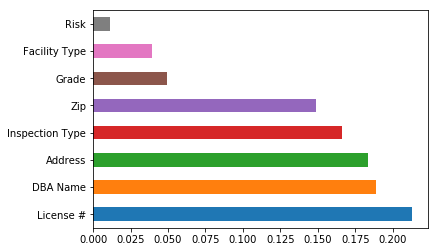

In [720]:
X = df_chicago.iloc[:,0:7]
X['Grade'] = df_chicago.iloc[:,-1]  #independent columns
y = df_chicago.iloc[:,-2]    #target column i.e price range
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [735]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
X_train, X_test, y_train, y_test = train_test_split(X[:5000], y[:5000], test_size=0.4, random_state=0)
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
clf = AdaBoostRegressor() #RandomForestRegressor(n_estimators=10, max_depth=100)
#params = {'C': [0.1, 1., 10.]}
#params = {'n_estimators': [10,100],'max_depth': [10,100]}
params = {'n_estimators': [10,100],'learning_rate': [0.1, 0.2]}
grid = GridSearchCV(estimator=clf, 
                    param_grid=params,
                    cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, random_state=None),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 100], 'learning_rate': [0.1, 0.2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [736]:
y_pred = grid.best_estimator_.predict(X_train)
mse = np.mean((y_pred - y_train)**2)
mse

0.4573941178119698

In [737]:
y_pred = grid.best_estimator_.predict(X_test)
mse = np.mean((y_pred - y_test)**2)
mse
#grid.estimator.feature_importances_

0.43688160653900837

In [739]:
pd.DataFrame(grid.best_estimator_.feature_importances_, df_chicago.iloc[:,0:7].columns.values)

,0
DBA Name,0.138348
License #,0.058618
Facility Type,0.248602
Risk,0.000000
Address,0.102031
Zip,0.161385
Inspection Type,0.291016


[0.18 0.21 0.04 0.01 0.18 0.15 0.23]


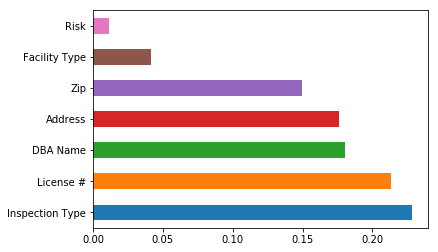

In [740]:
X = df_chicago.iloc[:,0:7]
y = df_chicago.iloc[:,-1]    #target column i.e price range
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [741]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score as precision
from sklearn.metrics import recall_score as recall
from sklearn.metrics import f1_score as f1

clf = RandomForestClassifier()
params = {'n_estimators': [10,100],'max_depth': [100, 200]}
grid = GridSearchCV(estimator=clf, 
                    param_grid=params,
                    cv=3)
grid.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 100], 'max_depth': [100, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [742]:
y_pred = grid.best_estimator_.predict(X_test)
print(precision(y_test, y_pred, average='micro'))
print(recall(y_test, y_pred, average='micro'))
print(f1(y_test, y_pred, average='micro'))

0.5525
0.5525
0.5525


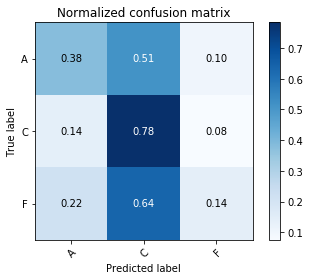

In [743]:
from sklearn.metrics import confusion_matrix
title = 'Normalized confusion matrix'
class_names = ['A', 'C', 'F']
np.set_printoptions(precision=2)
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        # ... and label them with the respective list entries
        xticklabels=class_names, yticklabels=class_names,
        title=title,
        ylabel='True label',
        xlabel='Predicted label')    
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
#fig.tight_layout()
plt.show()

### Potential Data Pooling/Bucketing & ETL

| _               | NY Field            | Chicago Field    | Vegas Field         |
|-----------------|---------------------|------------------|---------------------|
| Location Type   | Cusines Description | Facility Type    | Category Name       |
| Violations      | Aggregations        | Violations Regex | Inspection Demerits |
| Inspection Type | Inspection Type     | Inspection Type  | Inspection Type     |
| Past Grade      | Aggregations        | Aggregations     | Current Grade       |
| Grade (Target)  | Grade               | Results          | Inspection Grade    |
| Zip Code        | ZIPCODE             | Zip              | Zip                 |

### Feature Engineering

* Is the restaurant part of a chain? Name Appears more then one time.
* Time, Season, Part of Day factor into inspection.
* Nearby Restaurants with Pass/Fail Grades. 
* historical data, time series

### External Data
* Restaurant Age?
* Reviews of the Location on Yelp or Google?
* Population Density?
* Revenue?